In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, auc




In [2]:
dfClientes = pd.read_excel('caso_estudo.xlsx', sheet_name='clientes')
dfLojas = pd.read_excel('caso_estudo.xlsx', sheet_name='lojas')
dfProdutos = pd.read_excel('caso_estudo.xlsx', sheet_name='produtos')
dfVendas = pd.read_excel('caso_estudo.xlsx', sheet_name='vendas')
dfPagamentos = pd.read_excel('caso_estudo.xlsx', sheet_name='pagamentos')
dfPromo = pd.read_csv('caso_estudo_venda_promocao.csv', sep=';')


Análise Preliminar

In [3]:
dfClientes.head(5)

,id,nome,sexo,dt_nasc
0,1,Lavinia Sousa,F,5/2/1975
1,2,Caio Pereira,M,4/16/1978
2,3,Júlio Azevedo,M,11/4/1952
3,4,Sarah Goncalves,F,2/24/1937
4,5,Gabrielle Martins,F,5/6/1953


In [4]:
#Investigando os dados nulos
dfClientes.isnull().sum()

id         0
nome       4
sexo       4
dt_nasc    4
dtype: int64

In [5]:
#Mostrar onde estão os valores nulos
dfClientes[dfClientes.isnull().T.any()]

,id,nome,sexo,dt_nasc
263,264,NaN,F,7/29/1997
264,265,NaN,M,2/7/1979
268,269,NaN,F,NaN
269,270,NaN,M,NaN
276,277,Brenda Santos,F,NaN
282,283,Amanda Barros,F,NaN
287,288,Victor Ribeiro,NaN,12/17/1974
290,291,Clara Pinto,NaN,12/25/1980
294,295,Tiago Lima,NaN,7/26/1973
301,302,Guilherme Cardoso,NaN,3/9/1998


In [6]:
#Saber quais os valores da tabela
dfClientes.sexo.unique()

array(['F', 'M', nan], dtype=object)

In [7]:
dfProdutos

,id,produto,valor
0,1,mouse,20.0
1,2,teclado,30.0
2,3,laptop básico,2300.0
3,4,laptop gamer,5300.0
4,5,monitor,1500.0
5,6,impressora,700.0
6,7,carregador,150.0
7,8,cadeira,540.0
8,9,mesa,860.0
9,10,xxx-231a,3211352.0


<Axes: >

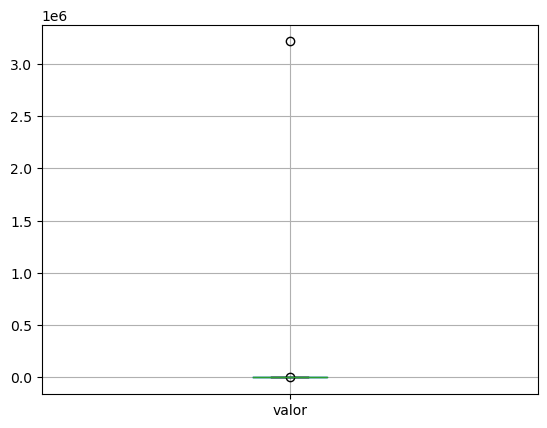

In [8]:
#Entendendo sobre outliers, dados que não fazem parte do conjunto
dfProdutos.boxplot(column=['valor'])

In [9]:
#Criando filtro []
dfProdutos[dfProdutos.valor>3000000]

,id,produto,valor
9,10,xxx-231a,3211352.0


In [10]:
dfProdutos[dfProdutos.valor<3000000].boxplot(column=['valor'])

<Axes: >

In [11]:
dfVendas[dfVendas.id_produto==10]

,id,id_cliente,id_loja,id_produto,dt_venda
7,8,543,10,10,2018-01-06
9,10,724,3,10,2018-01-07
20,21,270,2,10,2018-01-12
22,23,665,10,10,2018-01-12
28,29,299,5,10,2018-01-13
...,...,...,...,...,...
2906,2907,907,2,10,2020-08-23
2946,2947,387,3,10,2020-09-10
2956,2957,35,7,10,2020-09-14
2966,2967,405,3,10,2020-09-17


In [12]:
#Validar se nossas tabelas fazem sentido
dfVendas.describe()

,id,id_cliente,id_loja,id_produto,dt_venda
count,3000.000000,3000.000000,3000.000000,3000.000000,3000
mean,1500.500000,500.763667,4.538333,4.435000,2019-05-17 17:48:28.799999744
min,1.000000,1.000000,1.000000,1.000000,2018-01-04 00:00:00
25%,750.750000,254.750000,2.000000,3.000000,2018-09-09 00:00:00
50%,1500.500000,503.500000,4.000000,3.000000,2019-05-20 00:00:00
75%,2250.250000,742.000000,7.000000,6.000000,2020-01-29 06:00:00
max,3000.000000,1000.000000,10.000000,10.000000,2020-09-27 00:00:00
std,866.169729,285.322282,2.922221,2.511018,NaN


In [13]:
dfPagamentos.describe()

,id,id_venda,dt_pgto
count,2072.000000,2072.000000,2072
mean,1036.500000,1491.731660,2019-06-06 05:37:45.637065472
min,1.000000,1.000000,2018-01-10 00:00:00
25%,518.750000,746.250000,2018-10-01 12:00:00
50%,1036.500000,1501.500000,2019-06-10 00:00:00
75%,1554.250000,2220.500000,2020-02-08 00:00:00
max,2072.000000,2997.000000,2020-11-03 00:00:00
std,598.279199,864.865583,NaN



DataCleaning

In [14]:
#Acessar uma localização = .loc[]
# Abaixo estamos substituindo os dados
dfClientes.loc[dfClientes.nome.isnull(), 'nome'] = 'Sem nome'
dfClientes.loc[dfClientes.sexo.isnull(),'sexo'] = 'O'
dfClientes.loc[dfClientes.dt_nasc.isnull(),'dt_nasc'] = '1/1/2020'

In [15]:
dfClientes.loc[[269, 287], :]

,id,nome,sexo,dt_nasc
269,270,Sem nome,M,1/1/2020
287,288,Victor Ribeiro,O,12/17/1974


In [16]:
dfProdutos.isnull().sum()

id         0
produto    0
valor      0
dtype: int64

OutLiers


In [17]:
#Apenas em dados Numéricos
dfProdutos.loc[9,'valor'] = dfProdutos.valor[9]/10000
dfProdutos

,id,produto,valor
0,1,mouse,20.0000
1,2,teclado,30.0000
2,3,laptop básico,2300.0000
3,4,laptop gamer,5300.0000
4,5,monitor,1500.0000
5,6,impressora,700.0000
6,7,carregador,150.0000
7,8,cadeira,540.0000
8,9,mesa,860.0000
9,10,xxx-231a,321.1352


In [18]:
dfProdutos.boxplot(column=['valor'])

<Axes: >

Consistencia

In [19]:
#Validar qual dado da tabela X está na tabela Y
dfVendas[~dfVendas.id_cliente.isin(dfClientes.id)].count()

id            0
id_cliente    0
id_loja       0
id_produto    0
dt_venda      0
dtype: int64

In [20]:
dfVendas[~dfVendas.id_loja.isin(dfLojas.id)]

,id,id_cliente,id_loja,id_produto,dt_venda


In [21]:
dfPagamentos[~dfPagamentos.id_venda.isin(dfVendas.id)]

,id,id_venda,dt_pgto


In [22]:
dfVendas[~dfVendas.id.isin(dfPagamentos.id_venda)]

,id,id_cliente,id_loja,id_produto,dt_venda
3,4,59,4,3,2018-01-05
5,6,52,8,3,2018-01-05
20,21,270,2,10,2018-01-12
21,22,465,2,3,2018-01-12
32,33,459,2,7,2018-01-13
...,...,...,...,...,...
2992,2993,764,2,7,2020-09-25
2994,2995,6,2,3,2020-09-27
2997,2998,731,2,4,2020-09-27
2998,2999,163,2,1,2020-09-27


##Dados Duplicados


In [23]:
#Validando se há clientes repetidos
dfClientes[dfClientes.nome.duplicated()]

,id,nome,sexo,dt_nasc
79,80,Anna Melo,F,8/10/1999
96,97,Beatrice Goncalves,F,11/22/1964
138,139,Kauê Araujo,M,5/31/1974
139,140,Leonor Sousa,F,8/2/1981
154,155,Luis Rodrigues,M,7/3/1973
...,...,...,...,...
986,987,Beatriz Cardoso,F,7/17/1984
990,991,Diogo Melo,M,7/24/2001
993,994,Eduardo Costa,M,12/18/1963
996,997,Laura Oliveira,F,6/15/1979


In [24]:
dfClientes[dfClientes.nome == 'Anna Melo']

,id,nome,sexo,dt_nasc
66,67,Anna Melo,F,11/6/1995
79,80,Anna Melo,F,8/10/1999


In [25]:
#Vendo se há linhas iguais
#Validando os dados mas tirando uma coluna
dfClientes.drop('id', axis=1).duplicated().sum()

0

In [26]:
dfProdutos.produto.duplicated().sum()

0

In [27]:
dfLojas.cidade.duplicated().sum()

0

In [28]:
#Achando o duplicado:
dfVendas.drop('id', axis=1).duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Length: 3000, dtype: bool

In [29]:
#Printando o duplicado
dfVendas[dfVendas.drop('id', axis=1).duplicated()]

,id,id_cliente,id_loja,id_produto,dt_venda
496,497,559,2,5,2018-06-22


In [30]:
#Visualizando mais detalhado
dfVendas[(dfVendas.id_cliente == 559) & (dfVendas.id_loja == 2) & (dfVendas.id_produto == 5)]

,id,id_cliente,id_loja,id_produto,dt_venda
495,496,559,2,5,2018-06-22
496,497,559,2,5,2018-06-22


In [31]:
dfPagamentos.drop('id', axis=1).duplicated().sum()

0

Formato de dados  


In [32]:
dfClientes.dt_nasc = pd.to_datetime(dfClientes.dt_nasc, format='%m/%d/%Y')
dfClientes

,id,nome,sexo,dt_nasc
0,1,Lavinia Sousa,F,1975-05-02
1,2,Caio Pereira,M,1978-04-16
2,3,Júlio Azevedo,M,1952-11-04
3,4,Sarah Goncalves,F,1937-02-24
4,5,Gabrielle Martins,F,1953-05-06
...,...,...,...,...
995,996,Ágatha Ribeiro,F,1946-02-08
996,997,Laura Oliveira,F,1979-06-15
997,998,Lara Oliveira,F,1946-03-15
998,999,Julian Cunha,M,1994-06-20


In [33]:
dfVendas

,id,id_cliente,id_loja,id_produto,dt_venda
0,1,393,9,3,2018-01-04
1,2,417,9,3,2018-01-04
2,3,374,7,8,2018-01-04
3,4,59,4,3,2018-01-05
4,5,18,9,1,2018-01-05
...,...,...,...,...,...
2995,2996,671,3,7,2020-09-27
2996,2997,586,8,3,2020-09-27
2997,2998,731,2,4,2020-09-27
2998,2999,163,2,1,2020-09-27


Index


In [34]:
dfClientes = dfClientes.set_index('id')
dfClientes

,nome,sexo,dt_nasc
id,,,
1,Lavinia Sousa,F,1975-05-02
2,Caio Pereira,M,1978-04-16
3,Júlio Azevedo,M,1952-11-04
4,Sarah Goncalves,F,1937-02-24
5,Gabrielle Martins,F,1953-05-06
...,...,...,...
996,Ágatha Ribeiro,F,1946-02-08
997,Laura Oliveira,F,1979-06-15
998,Lara Oliveira,F,1946-03-15


In [35]:
dfLojas = dfLojas.set_index('id')
dfPagamentos = dfPagamentos.set_index('id')
dfProdutos = dfProdutos.set_index('id')
dfVendas = dfVendas.set_index('id')

In [36]:
dfClientes.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000],
      dtype='int64', name='id', length=1000)

Data Fusion


In [37]:
df = dfVendas.join(dfClientes.add_prefix('cliente_'), on='id_cliente')
df = df.join(dfLojas.add_prefix('loja_'), on='id_loja')
df = df.join(dfProdutos.add_prefix('produto_'), on='id_produto')
df = df.join(dfPagamentos.set_index('id_venda'))

df

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,loja_cidade,produto_produto,produto_valor,dt_pgto
id,,,,,,,,,,,
1,393,9,3,2018-01-04,Gustavo Silva,M,1950-01-04,Palmas,laptop básico,2300.0,2018-01-24
2,417,9,3,2018-01-04,Leonor Almeida,F,1972-01-31,Palmas,laptop básico,2300.0,2018-02-17
3,374,7,8,2018-01-04,André Alves,M,1962-08-03,Salvador,cadeira,540.0,2018-02-14
4,59,4,3,2018-01-05,Rodrigo Ribeiro,M,1941-11-05,Belo Horizonte,laptop básico,2300.0,NaT
5,18,9,1,2018-01-05,Antônio Azevedo,M,1941-04-15,Palmas,mouse,20.0,2018-01-23
...,...,...,...,...,...,...,...,...,...,...,...
2996,671,3,7,2020-09-27,Ana Goncalves,F,1999-10-31,Curitiba,carregador,150.0,2020-10-17
2997,586,8,3,2020-09-27,Aline Pinto,F,1994-03-29,Brasília,laptop básico,2300.0,2020-10-02
2998,731,2,4,2020-09-27,Otávio Silva,M,1986-05-04,Rio de Janeiro,laptop gamer,5300.0,NaT


In [38]:
#Sempre bom adicionar prefixo pra diferenciar a mudança
df.isnull().sum()

id_cliente           0
id_loja              0
id_produto           0
dt_venda             0
cliente_nome         0
cliente_sexo         0
cliente_dt_nasc      0
loja_cidade          0
produto_produto      0
produto_valor        0
dt_pgto            928
dtype: int64

Feature Engineering

Feature Engineering


In [39]:
#Aqui setamos os não pagadores
df['pg'] = 1
df.loc[df.dt_pgto.isnull(), 'pg'] = 0
df

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,loja_cidade,produto_produto,produto_valor,dt_pgto,pg
id,,,,,,,,,,,,
1,393,9,3,2018-01-04,Gustavo Silva,M,1950-01-04,Palmas,laptop básico,2300.0,2018-01-24,1
2,417,9,3,2018-01-04,Leonor Almeida,F,1972-01-31,Palmas,laptop básico,2300.0,2018-02-17,1
3,374,7,8,2018-01-04,André Alves,M,1962-08-03,Salvador,cadeira,540.0,2018-02-14,1
4,59,4,3,2018-01-05,Rodrigo Ribeiro,M,1941-11-05,Belo Horizonte,laptop básico,2300.0,NaT,0
5,18,9,1,2018-01-05,Antônio Azevedo,M,1941-04-15,Palmas,mouse,20.0,2018-01-23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2996,671,3,7,2020-09-27,Ana Goncalves,F,1999-10-31,Curitiba,carregador,150.0,2020-10-17,1
2997,586,8,3,2020-09-27,Aline Pinto,F,1994-03-29,Brasília,laptop básico,2300.0,2020-10-02,1
2998,731,2,4,2020-09-27,Otávio Silva,M,1986-05-04,Rio de Janeiro,laptop gamer,5300.0,NaT,0


In [40]:
df['tempo_pg'] = (df.dt_pgto - df.dt_venda).dt.days
df

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,loja_cidade,produto_produto,produto_valor,dt_pgto,pg,tempo_pg
id,,,,,,,,,,,,,
1,393,9,3,2018-01-04,Gustavo Silva,M,1950-01-04,Palmas,laptop básico,2300.0,2018-01-24,1,20.0
2,417,9,3,2018-01-04,Leonor Almeida,F,1972-01-31,Palmas,laptop básico,2300.0,2018-02-17,1,44.0
3,374,7,8,2018-01-04,André Alves,M,1962-08-03,Salvador,cadeira,540.0,2018-02-14,1,41.0
4,59,4,3,2018-01-05,Rodrigo Ribeiro,M,1941-11-05,Belo Horizonte,laptop básico,2300.0,NaT,0,NaN
5,18,9,1,2018-01-05,Antônio Azevedo,M,1941-04-15,Palmas,mouse,20.0,2018-01-23,1,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,671,3,7,2020-09-27,Ana Goncalves,F,1999-10-31,Curitiba,carregador,150.0,2020-10-17,1,20.0
2997,586,8,3,2020-09-27,Aline Pinto,F,1994-03-29,Brasília,laptop básico,2300.0,2020-10-02,1,5.0
2998,731,2,4,2020-09-27,Otávio Silva,M,1986-05-04,Rio de Janeiro,laptop gamer,5300.0,NaT,0,NaN


In [41]:
df['cliente_idade'] = np.floor((pd.to_datetime('today') - df.cliente_dt_nasc)/np.timedelta64(1,'Y'))
df

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,loja_cidade,produto_produto,produto_valor,dt_pgto,pg,tempo_pg,cliente_idade
id,,,,,,,,,,,,,,
1,393,9,3,2018-01-04,Gustavo Silva,M,1950-01-04,Palmas,laptop básico,2300.0,2018-01-24,1,20.0,74.0
2,417,9,3,2018-01-04,Leonor Almeida,F,1972-01-31,Palmas,laptop básico,2300.0,2018-02-17,1,44.0,52.0
3,374,7,8,2018-01-04,André Alves,M,1962-08-03,Salvador,cadeira,540.0,2018-02-14,1,41.0,61.0
4,59,4,3,2018-01-05,Rodrigo Ribeiro,M,1941-11-05,Belo Horizonte,laptop básico,2300.0,NaT,0,NaN,82.0
5,18,9,1,2018-01-05,Antônio Azevedo,M,1941-04-15,Palmas,mouse,20.0,2018-01-23,1,18.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,671,3,7,2020-09-27,Ana Goncalves,F,1999-10-31,Curitiba,carregador,150.0,2020-10-17,1,20.0,24.0
2997,586,8,3,2020-09-27,Aline Pinto,F,1994-03-29,Brasília,laptop básico,2300.0,2020-10-02,1,5.0,29.0
2998,731,2,4,2020-09-27,Otávio Silva,M,1986-05-04,Rio de Janeiro,laptop gamer,5300.0,NaT,0,NaN,37.0



Análise


Lojas 


In [42]:
#Lojas e produtos que mais vendem
graf_dados = df.groupby('loja_cidade').count().produto_valor.sort_values(ascending=False)
graf_dados

loja_cidade
Rio de Janeiro    1087
Salvador           234
Vitória            231
Brasília           223
Belo Horizonte     221
Recife             211
São Paulo          207
Palmas             202
Curitiba           193
Santa Catarina     191
Name: produto_valor, dtype: int64

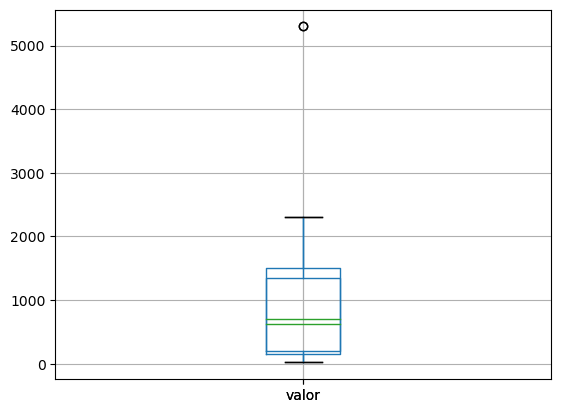

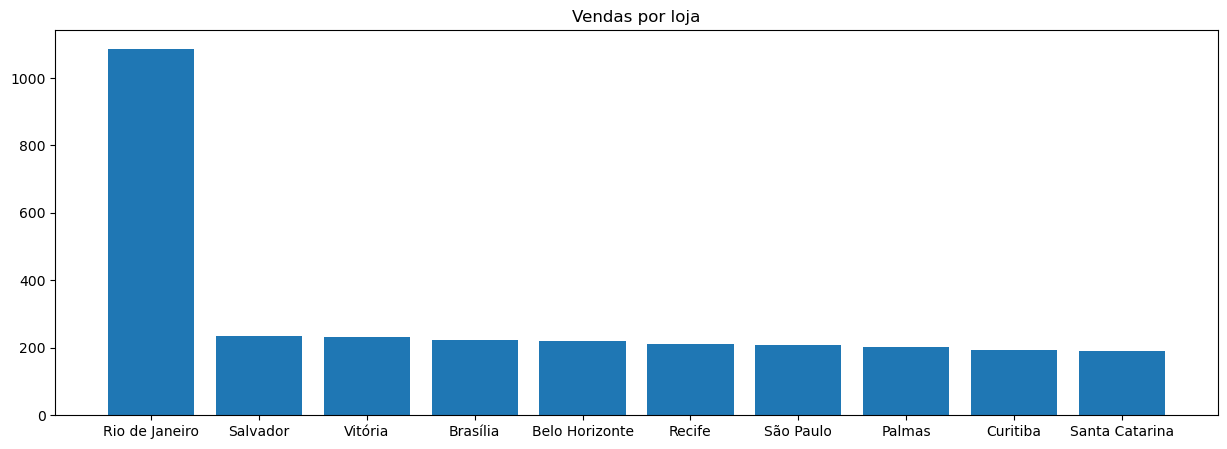

In [43]:
plt.figure(figsize=(15,5))
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Vendas por loja")
plt.show()


Produto

In [44]:
graf_dados = df.groupby('produto_produto').count().produto_valor.sort_values(ascending=False)
graf_dados

produto_produto
laptop básico    1395
teclado           204
impressora        191
monitor           187
xxx-231a          182
laptop gamer      180
mouse             172
mesa              171
carregador        164
cadeira           154
Name: produto_valor, dtype: int64

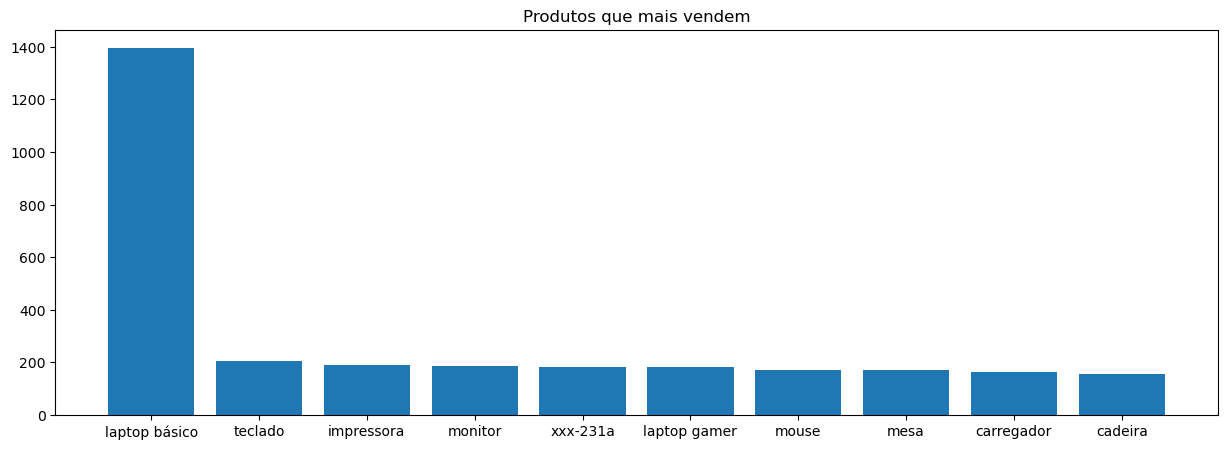

In [45]:
plt.figure(figsize=(15,5))
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Produtos que mais vendem")
plt.show()

Receita por loja


In [46]:
graf_dados = df[['loja_cidade', 'produto_valor']].groupby('loja_cidade').sum().produto_valor.sort_values(ascending=False)
graf_dados

loja_cidade
Rio de Janeiro    1.797907e+06
Brasília          3.779836e+05
Belo Horizonte    3.757225e+05
Salvador          3.752382e+05
Vitória           3.655850e+05
São Paulo         3.407579e+05
Recife            3.329236e+05
Palmas            3.168370e+05
Santa Catarina    3.133314e+05
Curitiba          3.032404e+05
Name: produto_valor, dtype: float64

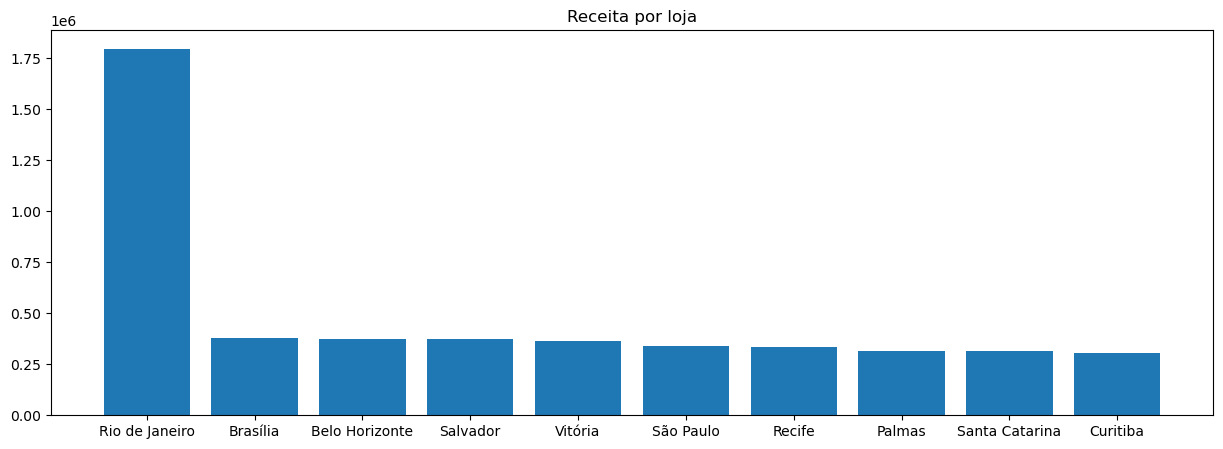

In [47]:
plt.figure(figsize=(15,5))
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Receita por loja")
plt.show()

Receita por produto

In [48]:
graf_dados = df[['produto_produto', 'produto_valor']].groupby('produto_produto').sum().produto_valor.sort_values(ascending=False)
graf_dados

produto_produto
laptop básico    3.208500e+06
laptop gamer     9.540000e+05
monitor          2.805000e+05
mesa             1.470600e+05
impressora       1.337000e+05
cadeira          8.316000e+04
xxx-231a         5.844661e+04
carregador       2.460000e+04
teclado          6.120000e+03
mouse            3.440000e+03
Name: produto_valor, dtype: float64

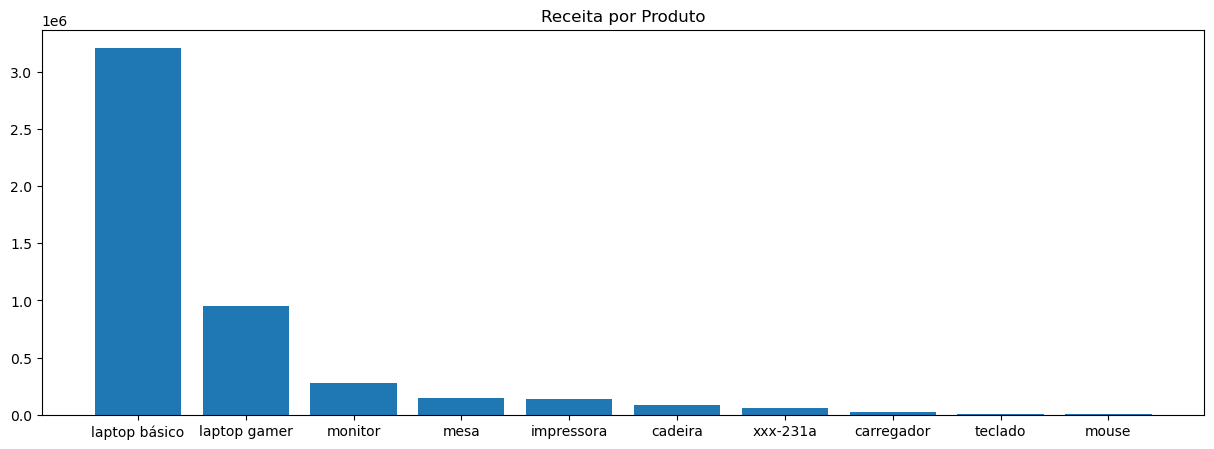

In [49]:

plt.figure(figsize=(15,5))
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Receita por Produto")
plt.show()


Subplots


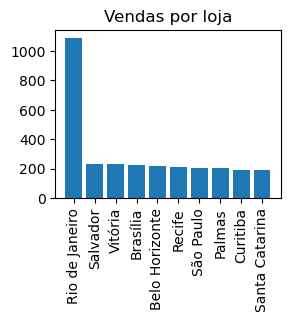

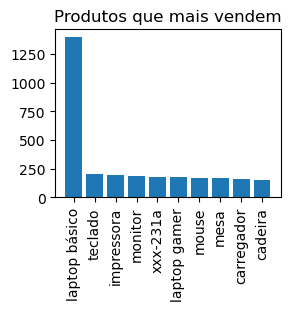

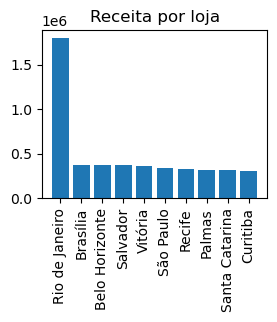

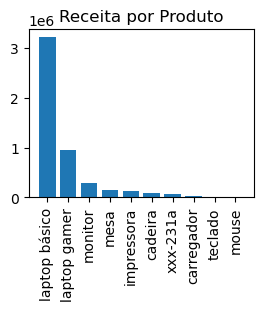

In [50]:
plt.Figure(figsize=(10,7))

plt.subplot(2,2,1)
graf_dados = df.groupby('loja_cidade').count().produto_valor.sort_values(ascending=False)
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Vendas por loja")
plt.xticks(rotation=90)
plt.show()


plt.subplot(2,2,2)
graf_dados = df.groupby('produto_produto').count().produto_valor.sort_values(ascending=False)
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Produtos que mais vendem")
plt.xticks(rotation=90)
plt.show()

plt.subplot(2,2,3)
graf_dados = df[['loja_cidade', 'produto_valor']].groupby('loja_cidade').sum().produto_valor.sort_values(ascending=False)
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Receita por loja")
plt.xticks(rotation=90)
plt.show()

plt.subplot(2,2,3)
graf_dados = df[['produto_produto', 'produto_valor']].groupby('produto_produto').sum().produto_valor.sort_values(ascending=False)
plt.bar(graf_dados.index, graf_dados.values)
plt.title("Receita por Produto")
plt.xticks(rotation=90)
plt.show()

plt.tight_layout()

Receita por CLiente


In [51]:
graf_dados = df[['cliente_nome', 'produto_valor']].groupby('cliente_nome').sum().produto_valor.sort_values(ascending=False)
graf_dados

cliente_nome
Leila Costa         28970.0000
Melissa Lima        25892.2704
Lavinia Carvalho    25261.1352
Fernanda Pinto      24660.0000
Felipe Castro       22920.0000
                       ...    
Julieta Barros         20.0000
Thaís Pinto            20.0000
Giovana Barbosa        20.0000
Diego Sousa            20.0000
José Pinto             20.0000
Name: produto_valor, Length: 861, dtype: float64

<Figure size 640x480 with 0 Axes>

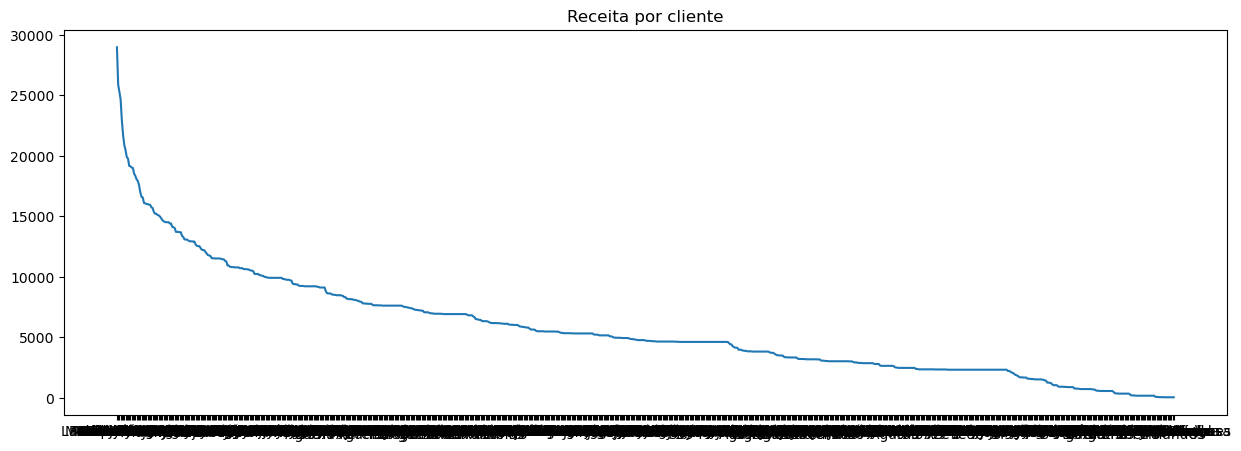

In [52]:
plt.figure(figsize=(15,5))
plt.plot(graf_dados.index, graf_dados.values)
plt.title("Receita por cliente")
plt.show()

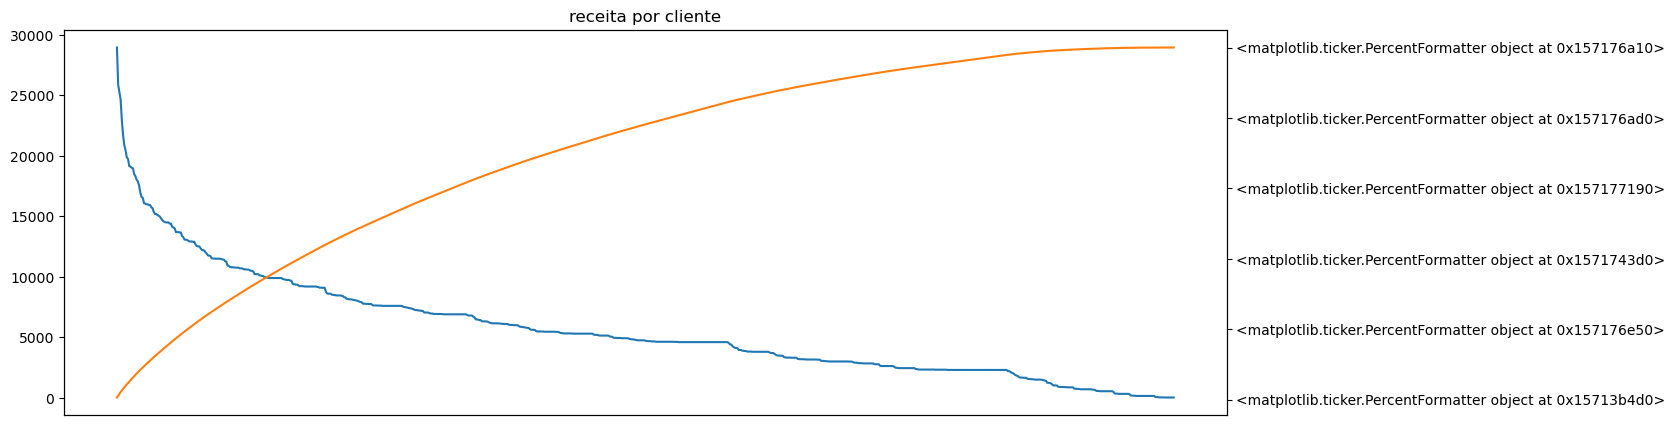

In [53]:
from matplotlib.ticker import PercentFormatter

fig, ax= plt.subplots(figsize=(15,5))
ax.plot(graf_dados.index, graf_dados.values, color='C0')
ax2 = ax.twinx()
ax2.plot(graf_dados.index, graf_dados.values.cumsum()/graf_dados.values.sum()*100, color='C1')
ax2.yaxis.set_major_formatter(PercentFormatter)
#Removendo Poluição do gráfico
ax2.axes.get_xaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
plt.title('receita por cliente')
plt.show()

In [54]:
receita_acumulada = graf_dados.cumsum()/graf_dados.sum()
receita_acumulada[receita_acumulada<0.60].count()/receita_acumulada.count()

0.3170731707317073

Pareto // Receita produtos

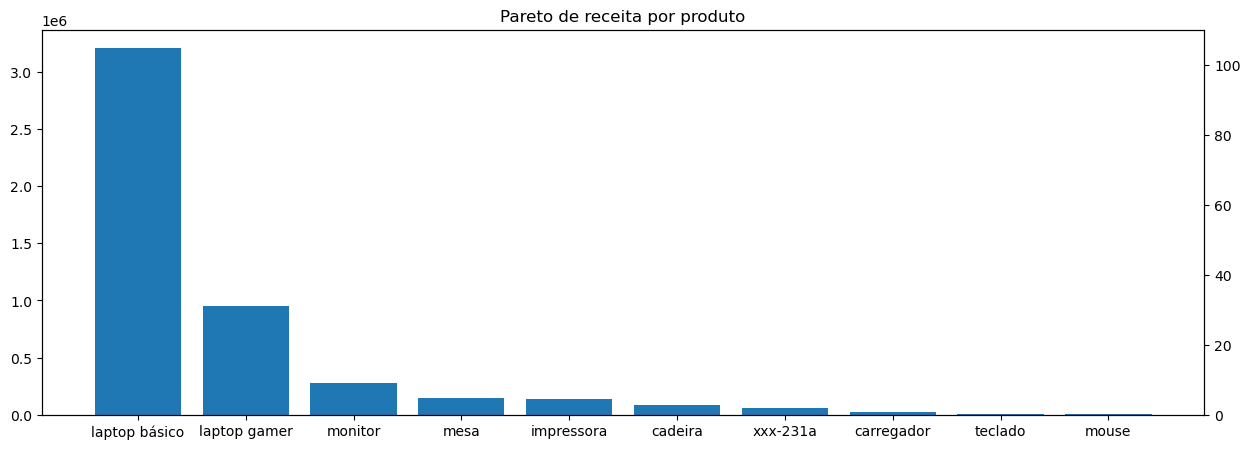

In [55]:
graf_dados = df[['produto_produto', 'produto_valor']].groupby('produto_produto').sum().produto_valor.sort_values(ascending=False)

fig, ax= plt.subplots(figsize=(15,5))
ax.bar(graf_dados.index, graf_dados.values, color='C0')
ax2.bar = ax.twinx()
ax2.plot(graf_dados.index, graf_dados.values.cumsum()/graf_dados.values.sum()*100, color='C1', marker= 'D')
ax2.yaxis.set_major_formatter(PercentFormatter())
plt.title('Pareto de receita por produto')
plt.ylim(0,110)
plt.show()

Receita combinando produto e loja

In [56]:
graf_dados = pd.DataFrame(columns=('Loja', 'Produto', 'Receita'))
for cidade in dfLojas.cidade:
    for produto in dfProdutos.produto:
        graf_dados = pd.concat([pd.DataFrame({
            'loja' : [cidade],
            'produto' : [produto],
            'receita' : [df.produto_valor[(df.loja_cidade == cidade) & (df.produto_produto == produto)].sum()]
        }), graf_dados], ignore_index=True)
graf_dados

,loja,produto,receita,Loja,Produto,Receita
0,Vitória,xxx-231a,7064.9744,NaN,NaN,NaN
1,Vitória,mesa,12040.0000,NaN,NaN,NaN
2,Vitória,cadeira,5400.0000,NaN,NaN,NaN
3,Vitória,carregador,2100.0000,NaN,NaN,NaN
4,Vitória,impressora,8400.0000,NaN,NaN,NaN
...,...,...,...,...,...,...
95,São Paulo,monitor,30000.0000,NaN,NaN,NaN
96,São Paulo,laptop gamer,63600.0000,NaN,NaN,NaN
97,São Paulo,laptop básico,223100.0000,NaN,NaN,NaN
98,São Paulo,teclado,510.0000,NaN,NaN,NaN


In [57]:
#Antes de usar heatmap, converter o DF em pivotTable
graf_dados = graf_dados.pivot_table(index='loja', columns='produto', values='receita', aggfunc='sum')
sns.heatmap(graf_dados)
sns.show()


AttributeError: module 'seaborn' has no attribute 'show'

In [ ]:
graf_dados = pd.DataFrame(columns=('Loja', 'Produto', 'Receita'))
for cidade in dfLojas.cidade:
    for produto in dfProdutos.produto:
        graf_dados = pd.concat([pd.DataFrame({
            'loja' : [cidade],
            'produto' : [produto],
            'receita' : [df.produto_valor[(df.loja_cidade == cidade) & (df.produto_produto == produto)].sum()]
        }), graf_dados], ignore_index=True)
graf_dados = graf_dados.sort_values(by="receita", ascending=False)
graf_dados

In [ ]:
#Gereando nova coluna na tabela
graf_dados['lojaprod'] = graf_dados.loja + '-' + graf_dados.Produto
graf_dados



Análise de tempo

Analise de vendas e receitas

In [ ]:
#Tempo médio de pagamento

df.tempo_pg.mean()

In [ ]:
df.boxplot('tempo_pg')
plt.title('Boxplot para tempo de pagamento')
plt.show()

In [ ]:
sns.histplot(data=df.tempo_pg, kde=True)
plt.title('Distribuição normal')
plt.show()

In [ ]:
df.tempo_pg.describe()

Tempo de pagamento por cidade e produto

In [ ]:
df.groupby('loja_cidade').mean().tempo_pg

In [ ]:
plt.figure(figsize=(7,4))
df[['loja_cidade','tempo_pg']].groupby('loja_cidade').boxplot('tempo_pg')
plt.title('boxplot para tempo de pagamento por cidade')
plt.xticks(rotation=90)
plt.show()


In [ ]:
df.groupby('produto_produto').tempo_pg.mean()

In [ ]:
plt.figure(figsize=(7,4))
df[['produto_produto','tempo_pg']].groupby('produto_produto').boxplot('tempo_pg')
plt.title('Boxplot para tempo de pagamento por produto')
plt.xticks(rotation=90)
plt.show()

Novo código


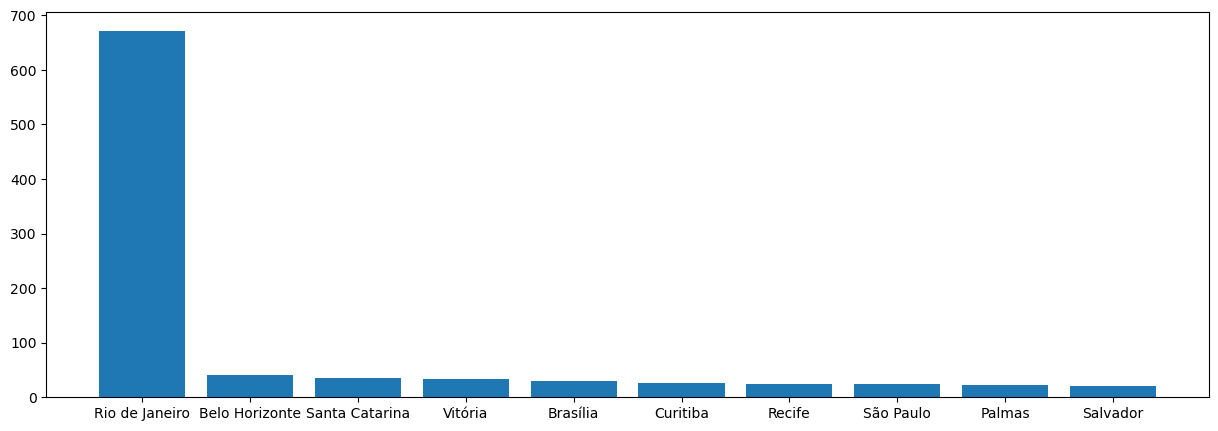

In [60]:
graf_dados = df[df.pg==0].groupby('loja_cidade').count().produto_valor.sort_values(ascending=False)\

plt.figure(figsize=(15,5))
plt.bar(graf_dados.index, graf_dados.values)
plt.show()

In [61]:
graf_dados = df.groupby('loja_cidade').mean().pg.sort_values(ascending=False)

TypeError: Could not convert Rodrigo RibeiroLara SouzaEnzo FernandesSamuel AraujoVinícius GoncalvesVitór LimaKauê CunhaPedro MartinsLuana PintoMaria CarvalhoKaua CostaJulian MartinsJúlia DiasClara AlvesBreno SouzaLuis CavalcantiIsabela LimaFernanda CastroRaissa OliveiraArthur SilvaBianca OliveiraNicole SousaCarolina AlmeidaLuis RodriguesKai AlmeidaMiguel MeloFelipe AzevedoVitor CardosoBianca CostaJulieta LimaLeila FerreiraVitória RochaMatheus AlvesÁgatha GoncalvesPedro RochaAna CunhaIsabela SouzaFelipe CastroAlex AlmeidaBreno SilvaBeatriz AraujoLeonardo SilvaAnna MeloSarah CardosoArthur GomesÁgatha GoncalvesLuís MeloAna GoncalvesMaria MeloAline SousaVictor RochaArthur AlvesThaís SousaFelipe AlmeidaTomás MeloMelissa LimaGabrielle BarrosDouglas PintoCarlos SouzaAmanda RibeiroMariana CardosoBeatriz BarbosaDavi DiasCarlos BarrosMatheus SousaGustavo CastroLuís SilvaKauan PintoGiovanna CostaBreno SouzaGustavo CavalcantiThaís CorreiaEduardo AlmeidaMurilo PereiraLuana CostaSofia AzevedoJoão PintoJulieta AraujoJúlio MartinsLuana SilvaCarolina AzevedoBreno CastroBianca GoncalvesLuana CostaKauan AzevedoRafael MeloCarlos GomesGuilherme CastroAlex AlmeidaLaura SilvaLuis RibeiroBruna CunhaLuís RochaAlice MeloBruna CorreiaVitoria RodriguesTânia PereiraRafael AzevedoMariana AzevedoLetícia FernandesBreno RochaDanilo MeloBianca CavalcantiBruna SousaMiguel CorreiaJulieta CostaLeila RochaGuilherme AzevedoSamuel BarbosaAline CunhaGabrielly FernandesMelissa CavalcantiEnzo GoncalvesDouglas PintoRafaela AzevedoCamila LimaGustavo BarbosaJosé CardosoMarina GomesClara GomesMariana FerreiraLuan FernandesIsabela PintoArthur SilvaLuiza SouzaRebeca RochaCarlos BarrosGustavo CastroVitória SouzaVitor MartinsMelissa AraujoCarolina FerreiraEstevan FernandesMartim CunhaMurilo OliveiraLuiza CardosoRaissa OliveiraAlex SantosNicolas DiasCarlos GomesIgor OliveiraMelissa FerreiraNicole DiasIsabela SouzaIsabela BarrosJulian SousaVitor AzevedoEduarda CostaSophia CostaDaniel SouzaYasmin SilvaCauã CunhaKai FerreiraFernanda SouzaVictor RochaÁgatha RibeiroSofia AlvesDanilo RochaAlex CorreiaAlex CorreiaKaua SousaRafael CavalcantiGabriela CavalcantiMelissa GoncalvesEmily SantosArthur AlvesDanilo MeloLarissa CunhaMatheus RochaLuiza LimaVitoria GomesBrenda CostaBreno PintoSofia FerreiraFernanda BarbosaCarla RochaJulia GoncalvesAline CorreiaFernanda GoncalvesOtávio SantosPedro MartinsClara AzevedoOtávio SilvaAntônio CardosoOtávio SilvaJoão SousaMartim CavalcantiLeonor SantosEduardo AlvesVitór LimaEnzo BarrosLarissa AlvesJulia BarbosaFábio AlmeidaMateus CavalcantiÁgatha CavalcantiSofia SilvaErick AlvesNicole FerreiraSofia SouzaSofia OliveiraDouglas CostaDanilo BarbosaJulian MartinsLarissa SousaAntônio AzevedoGustavo AlmeidaGabrielle FerreiraVinícius BarbosaVinicius OliveiraYasmin SousaJulieta FernandesLeonor SantosGabrielly OliveiraArthur LimaRenan CarvalhoLaura BarbosaLuís SousaDanilo SilvaLuiz OliveiraVitoria Gomes to numeric

In [ ]:
df

heatmap de inadimplência

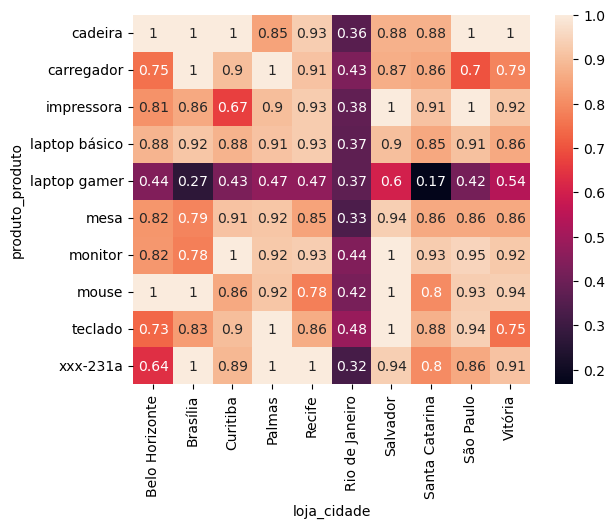

In [62]:
graf_dados = df.pivot_table(index='produto_produto', columns='loja_cidade', values='pg', aggfunc='mean')

sns.heatmap(graf_dados, annot=True)
plt.show()

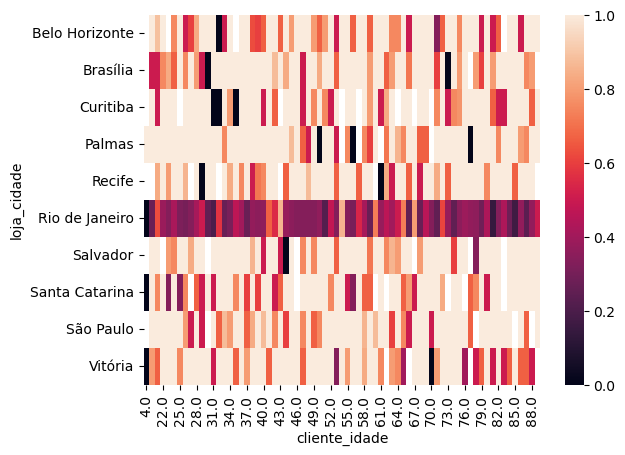

In [63]:
graf_dados = df.pivot_table(index='loja_cidade', columns='cliente_idade', values='pg', aggfunc='mean')

sns.heatmap(graf_dados)
plt.show()

Machine Learning

In [64]:
dfMl = df[['cliente_sexo','loja_cidade','produto_produto','produto_valor','cliente_idade','pg']]
dfMl = dfMl.replace([' ','-'],'_', regex=True)
dfMl

,cliente_sexo,loja_cidade,produto_produto,produto_valor,cliente_idade,pg
id,,,,,,
1,M,Palmas,laptop_básico,2300.0,74.0,1
2,F,Palmas,laptop_básico,2300.0,52.0,1
3,M,Salvador,cadeira,540.0,61.0,1
4,M,Belo_Horizonte,laptop_básico,2300.0,82.0,0
5,M,Palmas,mouse,20.0,82.0,1
...,...,...,...,...,...,...
2996,F,Curitiba,carregador,150.0,24.0,1
2997,F,Brasília,laptop_básico,2300.0,29.0,1
2998,M,Rio_de_Janeiro,laptop_gamer,5300.0,37.0,0


Normalização


In [65]:
dfMl['produto_valor'] = dfMl['produto_valor']/dfMl['produto_valor'].max()
dfMl['cliente_idade'] = dfMl['cliente_idade']/dfMl['cliente_idade'].max()
dfMl

,cliente_sexo,loja_cidade,produto_produto,produto_valor,cliente_idade,pg
id,,,,,,
1,M,Palmas,laptop_básico,0.433962,0.831461,1
2,F,Palmas,laptop_básico,0.433962,0.584270,1
3,M,Salvador,cadeira,0.101887,0.685393,1
4,M,Belo_Horizonte,laptop_básico,0.433962,0.921348,0
5,M,Palmas,mouse,0.003774,0.921348,1
...,...,...,...,...,...,...
2996,F,Curitiba,carregador,0.028302,0.269663,1
2997,F,Brasília,laptop_básico,0.433962,0.325843,1
2998,M,Rio_de_Janeiro,laptop_gamer,1.000000,0.415730,0


Dados categóricos



In [66]:
#Transformação de dados categóricos para numéricos
col_cat = ['cliente_sexo', 'loja_cidade', 'produto_produto']
dfMl_dummies = pd.get_dummies(dfMl[col_cat].astype(str), drop_first=False)
dfMl_dummies

,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo_Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,loja_cidade_Recife,loja_cidade_Rio_de_Janeiro,loja_cidade_Salvador,...,produto_produto_cadeira,produto_produto_carregador,produto_produto_impressora,produto_produto_laptop_básico,produto_produto_laptop_gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx_231a
id,,,,,,,,,,,,,,,,,,,,,
1,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,True,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
4,False,True,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2997,True,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2998,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False


In [67]:
dfMl = pd.concat([dfMl, dfMl_dummies], axis=1)
dfMl = dfMl.drop(col_cat, axis=1)
dfMl

,produto_valor,cliente_idade,pg,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo_Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,...,produto_produto_cadeira,produto_produto_carregador,produto_produto_impressora,produto_produto_laptop_básico,produto_produto_laptop_gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx_231a
id,,,,,,,,,,,,,,,,,,,,,
1,0.433962,0.831461,1,False,True,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,0.433962,0.584270,1,True,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,0.101887,0.685393,1,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,0.433962,0.921348,0,False,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5,0.003774,0.921348,1,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.028302,0.269663,1,True,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
2997,0.433962,0.325843,1,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
2998,1.000000,0.415730,0,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
